# GP Fitting
Author: Allen Ross  
Date: 5/18/21  

## Setup

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary, set_trainable
# %matplotlib 
# plt.ioff()

In [2]:
# Helper functions
def gp_predict_fun(gp, X, Y, x_min, x_max, x_idx, unit_idx, unit_label, num_funs=10):  
    """
    Plot marginal closed-form posterior distribution.
    """
    
    # Create test points
    x_new = np.zeros_like(X)
    x_new[:,x_idx] = np.linspace(x_min, x_max, X.shape[0])
    x_new[:, unit_idx] = unit_label

    # Predict mean and variance on new data
    mean, var = gp.predict_f(x_new)

    # Pull some posterior functions
    tf.random.set_seed(1) 
    samples = gp.predict_f_samples(x_new, num_funs) 

    # Generate plot
#     p = plt.figure(figsize=(10, 5))
    fig, ax = plt.subplots(figsize=(10,5))
    p = sns.scatterplot(x=X[:,x_idx],
                    y=Y.flatten(),
                    hue=X[:,unit_idx].astype(int).astype(str),
                        legend=False)
    p = sns.lineplot(x=x_new[:,x_idx],
                 y=mean.numpy().flatten(),
                 linewidth=2,
                    color='darkgreen')
    p.fill_between(
        x_new[:, x_idx],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color='lightgreen',
        alpha=0.5,
    )
    p.plot(x_new[:,x_idx], 
           samples[:, :, 0].numpy().T,# "C0", 
           color='dimgray',
           linewidth=0.5)
#     plt.close()
    return(p)

def calc_bic(loglik, n, k):
    return k*np.log(n)-2*loglik

# Kernel search helper functions
def coregion_freeze(k):
    """ Freeze parameters associated with coregion kernel, for individual level effets. """
    
    if k.name == 'coregion':
        #print('Found coregion kernel, freezing parameters.')
        k.W.assign(np.zeros_like(k.W))
        k.kappa.assign(np.ones_like(k.kappa))
        set_trainable(k.W, False)
        set_trainable(k.kappa, False)
#         set_trainable(k, False)

def coregion_search(kern_list):
    """ Search through GP kernel list to find coregion kernels. """
    
    for k in kern_list:
        if hasattr(k, 'kernels'):
            coregion_search(k.kernels)
        else:
            coregion_freeze(k)

def print_kernel_names(kernel):
    names = []
    if hasattr(kernel,'kernels')==False:
        return kernel.name
    for i in kernel.kernels:
        if i.name == 'sum':
            sub_names = print_kernel_names(i)
#             names.append('+'.join([x.name for x in i.kernels]))
            names.append('+'.join(sub_names))

        elif i.name == 'product':
            sub_names = print_kernel_names(i)
#             names.append('*'.join([x.name for x in i.kernels]))
            names.append('*'.join(sub_names))

        else:
            names.append(i.name)

    return(names)

def kernel_test(X, Y, k, no_tune=None, verbose=False):
    """
    This function evaluates a particular kernel selection on a set of data. 
    
    Inputs:
        X (array): design matrix
        Y (array): output matrix
        k (gpflow kernel): specified kernel
        
    Outputs:
        m (gpflow model): fitted GPflow model
    
    """
    # Specify model
    m = gpflow.models.GPR(data=(X, Y),
                          kernel=k,
                          mean_function=None)
    
    # Check if some parameters shouldn't be trained
    if no_tune:
        for p in no_tune:
            set_trainable(m.kernel.kernels[p], False)
            
    # Randomize initial values
    np.random.seed(9012)
    for p in m.trainable_parameters:
        p.assign(
            np.random.uniform(
                size=p.numpy().size
            ).reshape(p.numpy().shape)
        )
    
    # Optimization step for hyperparameters
    gpflow.optimizers.Scipy().minimize(m.training_loss,
                                       m.trainable_variables)
    
    # Plot marginal outputs
#     p = gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)

#     print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')
    # Calculate information criteria
    bic = round(calc_bic(loglik=m.log_marginal_likelihood().numpy(),
                   n=X.shape[0],
                   k=len(m.parameters)),
               2)
    if verbose:
        print(f'Model: {print_kernel_names(k)}, BIC: {bic}')
    
    # Return fitted GP model, plot, and bic
    return(m,# p, 
           bic)

### Read Data

In [3]:
# Read data in
df = pd.read_csv('simulated_data.csv')
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k1_obs']].to_numpy().reshape(-1,1)
df.head()

,unit,treatment,time,k1_obs,k2_obs,k3_obs,k4_obs
0,0.0,0.0,2.5,1.22,-0.08,0.22,0.92
1,0.0,0.0,5.1,1.05,-0.61,-0.15,1.52
2,0.0,0.0,5.5,-0.01,-0.85,-0.36,1.41
3,0.0,0.0,6.1,-0.79,-0.17,-0.49,2.20
4,0.0,0.0,6.8,0.51,-0.06,-0.70,2.60


### Fit Separate Models

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.21895  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.882504 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.409473 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

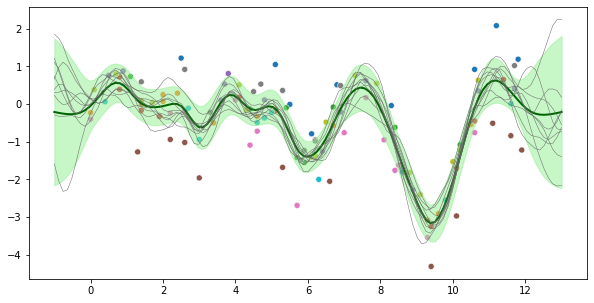

In [4]:
# Fit overall model with time only kernel function
k = gpflow.kernels.Matern52(active_dims=[2])
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)
p = gp_predict_fun(gp=m, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')
bic = calc_bic(loglik=m.log_marginal_likelihood().numpy(),
               n=X.shape[0],
               k=len(m.trainable_parameters))
print(f'BIC: {bic}')

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.4615211867714142                     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.7658263380783121                     │
├────────────────────────────────────┼───────────┼──────────────────┼─

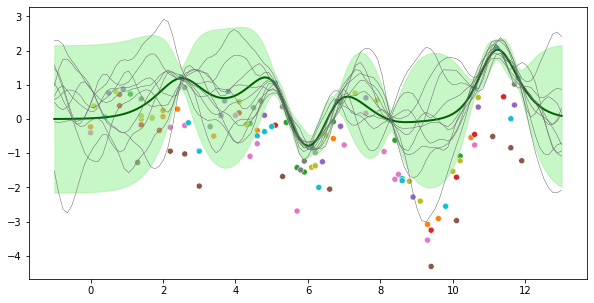

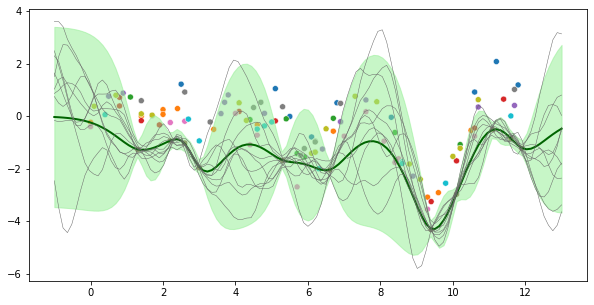

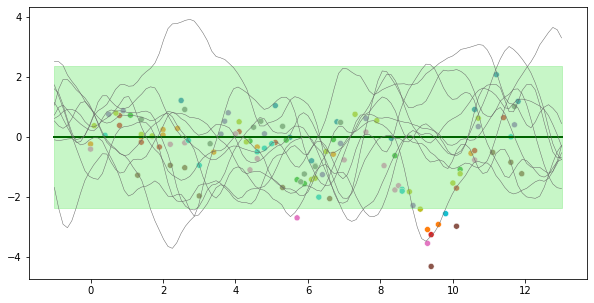

In [125]:
# Fit GP model with individual level effects
k = (gpflow.kernels.Matern52(active_dims=[2]) * 
    gpflow.kernels.Coregion(output_dim=len(np.unique(X[:,0]))+1,
                            rank=1,active_dims=[0]))
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

# Deal with coregion kernel
m.kernel.kernels[1].W.assign(np.zeros_like(m.kernel.kernels[1].W))
set_trainable(m.kernel.kernels[1].W, False)
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)
gp_predict_fun(gp=m, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
gp_predict_fun(gp=m, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=5)
gp_predict_fun(gp=m, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10)
print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')
bic = calc_bic(loglik=m.log_marginal_likelihood().numpy(),
               n=X.shape[0],
               k=len(m.trainable_parameters))
print(f'BIC: {bic}')

B = [[0.82725855 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.75222491 0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.80577567 0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.92279385 0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.77097754 0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         2.09859571
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.67279616 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.70260193 0.         0.         0.        ]
 [0.         0.         0.         0.       

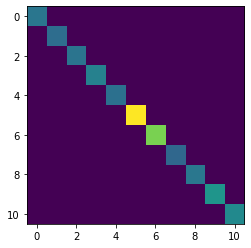

In [126]:
B = m.kernel.kernels[1].output_covariance().numpy()
print("B =", B)
_ = plt.imshow(B)

### Kernel Search
Now we need to specify the kernels we want to test

In [143]:
kernel_list = [gpflow.kernels.Constant(active_dims=[2]),
               gpflow.kernels.Linear(active_dims=[2]),
               gpflow.kernels.Matern32(active_dims=[2]),
               #gpflow.kernels.Periodic(),
               gpflow.kernels.SquaredExponential(active_dims=[2]),
               gpflow.kernels.White(active_dims=[2])]#,
#                gpflow.kernels.Coregion(
#                        output_dim=len(np.unique(X[:,0]))+1,
#                        rank=1,active_dims=[0])]

# Loop through kernels for single dimension test first
best_kern = None
best_bic = np.Inf
for k in kernel_list:
    m,bic = kernel_test(X, Y, k)
    if bic < best_bic:
        best_kern = k
        best_bic = bic
print(f'Best BIC: {best_bic}, kernel: {best_kern.name}')

Best BIC: 287.88, kernel: squared_exponential


In [152]:
# Now try to add individual effects
best_model = None
best_kern = None
best_bic = np.Inf
for k in kernel_list:
    k = k + gpflow.kernels.Constant() * gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0])
    coregion_search(k.kernels)
    m,bic = kernel_test(X, Y, k)
    if bic < best_bic:
        best_model = m
        best_kern = k
        best_bic = bic
print(f'Best BIC: {best_bic}, kernel: {print_kernel_names(best_kern)}')

Best BIC: 47.68, kernel: ['matern32', 'constant*coregion']


In [154]:
# Now try to add individual effects and individual slope effects
best_kern = None
best_bic = np.Inf
for k in kernel_list:
    k = (k * gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0]) + 
        gpflow.kernels.Constant() * gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0]))
    coregion_search(k.kernels)
    m,bic = kernel_test(X, Y, k)
    if bic < best_bic:
        best_kern = k
        best_bic = bic
print(f'Best BIC: {best_bic}, kernel: {print_kernel_names(best_kern)}')

Best BIC: 322.11, kernel: ['matern32*coregion', 'constant*coregion']


Best kernel from round 0 is squared_exponential with bic 287.88
Found better kernel in next layer

Best kernel from round 1 is sum with bic 44.52
Found better kernel in next layer

Best kernel from round 2 is sum with bic 40.78
Found better kernel in next layer



'squared_exponential+coregion+matern32'

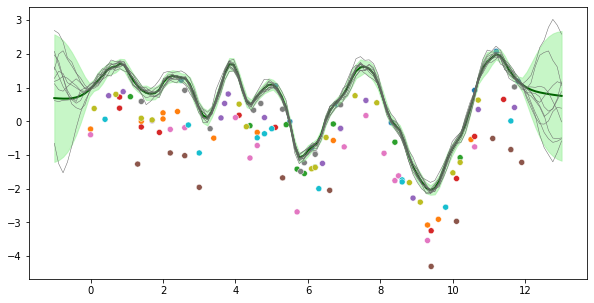

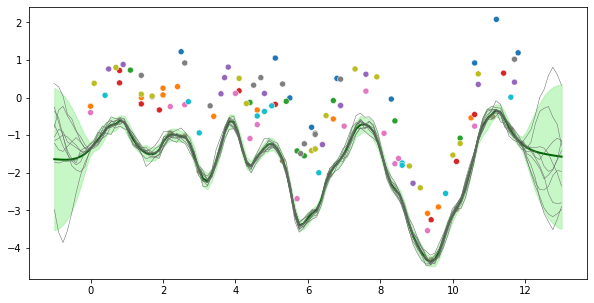

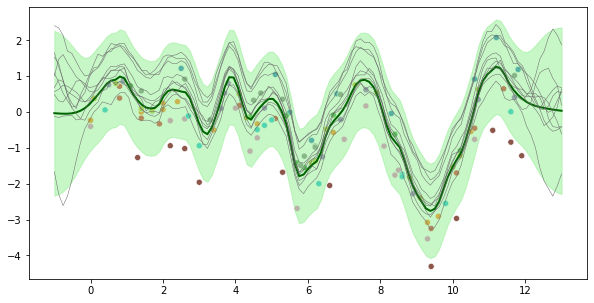

In [11]:
# Put it all together
# Search through marginal effects, individual offsets, and individual slopes
np.random.seed(9012)
max_depth = 3
best_kern = None
best_bic = np.Inf
best_bic_last_round = np.Inf
best_model = None
k_best = None
for d in range(max_depth):
    for k in kernel_list:
#         print(print_kernel_names(k))
        for i in range(2):
            if i == 1:
                k_new = (k * gpflow.kernels.Coregion(
                       output_dim=len(np.unique(X[:,0]))+1,
                       rank=1,active_dims=[0])) 
                coregion_search(k_new.kernels)
            else:
                k_new = k
            
            # Attach best previous kernel
            if k_best!=None:
                k_new = k_best + k_new

            # Randomize initial values
            for p in k_new.trainable_parameters:
                p.assign(
                    np.random.uniform(
                        size=p.numpy().size
                    ).reshape(p.numpy().shape)
                )
            # Run kernel test
            m,bic = kernel_test(X, Y, k_new)
            if bic < best_bic:
                best_kern = k_new
                best_bic = bic
                best_model = m
    # Save best kernel from round
    print(f'Best kernel from round {d} is {best_kern.name} with bic {best_bic}')
    
    # See if we have done better than the previous round
    if best_bic < best_bic_last_round:
        print(f'Found better kernel in next layer\n')
        best_bic_last_round = best_bic
        k_best = best_kern
    else:
        print(f'No better kernels, stopping search\n')
        break
        
# Fit final model
m,bic = kernel_test(X, Y, best_kern)
gp_predict_fun(gp=m, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0);
gp_predict_fun(gp=m, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=5);
gp_predict_fun(gp=m, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10);
'+'.join(print_kernel_names(best_kern))

In [12]:
best_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.8910955334951612
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.5346515674054532
GPR.kernel.kernels[1].W,Parameter,Identity,,False,"(11, 1)",float64,[[0....
GPR.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(11,)",float64,"[5.19627370e-01, 9.77586929e-02, 2.45997801e-02..."
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.10396821380559028
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,0.40207122543743823
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.009684194352853151


Now let's define a function to search easier.

In [178]:
# def multiplication_test()

def kernel_search(X, y, 
                  max_depth,
                  cat_vars,
                  con_vars = None,
                  kern_list = None):
    """
    This function performs a search over kernel-space for the best representations.
    """
    
    # Set random seed for reproducibility
    np.random.seed(9012)
    
    ## Placeholder variables
    # Best overall variables
    final_model = None
    final_kern = None
    final_feats = []
    final_bic = np.Inf
    
    # Best round variables
    best_kern = None
    best_bic = np.Inf
    best_bic_last_round = np.Inf
    #best_model = None
    best_feat_round = None 
    k_best = None
    feat_list = []
    
    # Intermediate variables
    temp_kernel = None
    
    # For each level in depth of search
    for d in range(max_depth):
        print(f'Starting depth {d}')
        
        # Search over each feature
        for f in range(X.shape[1]):
            print(f'Working on feature {f}')
            # If the feature is categorical just try coregion kernel
            if f in cat_vars:
                k_list = [gpflow.kernels.Coregion(output_dim=len(np.unique(X[:,f])) + 1,
                                                  rank=1,
                                                  active_dims=[f])]
            # Otherwise modify the kernel list to just try the single active feature
            else:
                k_list = kern_list
                for k_ in k_list:
                    k_.active_dims = np.array([f])
            
            # Now try each operation (addition, multiplication)
            for op in ['+','*']:
                
                # Start with multiplication operations
                if op == '*':
                    
                    # If there are no current best kernels then multiplication isn't necessary
                    if k_best == None:
                        break
                    
                    # Otherwise need to deal with current best kernel
                    else:
                        
#                         # Placeholder to modify best kernel
#                         k_new = gpflow.utilities.deepcopy(k_best)
                        
                        # See if we have a sum, if not then kernel combination is easy
                        if k_best.name != 'sum':
                            # Cycle through all new kernel options
                            for k in k_list:
                                k_new = k_best * k
                                
                                # Set coregion effect for individuals
                                try:
                                    coregion_search(k_new.kernels)
                                except AttributeError:
                                    pass

#                                 # Randomize initial values
#                                 for p in k_new.trainable_parameters:
#                                     p.assign(
#                                         np.random.uniform(
#                                             size=p.numpy().size
#                                         ).reshape(p.numpy().shape)
#                                     )
                                
                                # Run kernel test
                                try:
                                    m,bic = kernel_test(X, Y, k_new)
                                except:
                                    print('Invalid matrix input, skipping')
                                    break
                                
                                print(print_kernel_names(k_new))
                                print(bic)

                                if bic < best_bic:
                                    best_kern = k_new
                                    best_bic = bic
                                    best_model = m
                                    best_feat = f
                        
                        else:
                            print('Separate multiplications!')
                            # Pull off one piece of best kernel
                            for k_idx in range(len(k_new.kernels)):

                                # Cycle through all new kernel options
                                for k in k_list:
                                    k_test = gpflow.utilities.deepcopy(k_new)
                                    k_test.kernels[k_idx] = k_test.kernels[k_idx] * k

                                    # Set coregion effect for individuals
                                    try:
                                        coregion_search(k_new.kernels)
                                    except AttributeError:
                                        pass
                                    
#                                     # Randomize initial values
#                                     for p in k_new.trainable_parameters:
#                                         p.assign(
#                                             np.random.uniform(
#                                                 size=p.numpy().size
#                                             ).reshape(p.numpy().shape)
#                                         )

                                    # Run kernel test
                                    try:
                                        m,bic = kernel_test(X, Y, k_test)
                                    except:
                                        print('Invalid matrix input, skipping')
                                        break
                                    
                                    print(print_kernel_names(k_test))
                                    print(bic)

                                    if bic < best_bic:
                                        best_kern = k_test
                                        best_bic = bic
                                        best_model = m
                                        best_feat = f
                
                # Otherwise follow addition operations
                else:
                    print('Addition tests')
                    # Now loop through each new kernel option
                    for k in k_list:
                        
                        # Deal with single coregion kernel
                        if k.name == 'coregion':
                            k = gpflow.kernels.Constant() * k
                        
                        # If no previous kernel then use single kernel
                        if k_best == None:
                            k_new = k
                        # Sum kernels
                        elif op == '+':
                            k_new = k_best + k
#                         else:
#                             k_new = k_best * k

                        # Set coregion effect for individuals
                        try:
                            coregion_search(k_new.kernels)
                        except AttributeError:
                            pass

#                         # Randomize initial values
#                         for p in k_new.trainable_parameters:
#                             p.assign(
#                                 np.random.uniform(
#                                     size=p.numpy().size
#                                 ).reshape(p.numpy().shape)
#                             )

                        # Run kernel test
                        try:
                            m,bic = kernel_test(X, Y, k_new)
                        except:
                            print('Invalid matrix input, skipping')
                            break
                            
                        print(print_kernel_names(k_new))
                        print(bic)

                        if bic < best_bic:
                            best_kern = k_new
                            best_bic = bic
                            best_model = m
                            best_feat = f
                    
        # See if we have done better than the previous round
        if best_bic < best_bic_last_round:
            print(f'Found better kernel in current layer!')
            
            kernel_output = print_kernel_names(best_kern)
            if type(kernel_output) == list:
                kernel_output = '+'.join(kernel_output)
            print(f'Best kernel from round {d} is {kernel_output} from feature {best_feat} with bic {best_bic}\n')
            
            # Save informaiton
            best_bic_last_round = best_bic
            k_best = best_kern
            final_model = gpflow.utilities.deepcopy(best_model)
            feat_list.append(best_feat)
        else:
            print(f'No better kernels, stopping search\n')
            break
        
    # Fit final model
    # m,bic = kernel_test(X, Y, k_best)
    final_kern_string = '+'.join(print_kernel_names(final_model.kernel))
    if type(final_kern_string) == list:
            final_kern_string = '+'.join(final_kern_string)
    print(final_kern_string)
    print(f'Feature indexes: {feat_list}')
    # Return string and kernel
    return final_model

Starting depth 0
Working on feature 0
Addition tests
['constant', 'coregion']
372.76
Working on feature 1
Addition tests
['constant', 'coregion']
379.75
Working on feature 2
Addition tests
constant
375.07
linear
363.7
matern32
288.64
squared_exponential
287.88
white
393.42
Found better kernel in current layer!
Best kernel from round 0 is squared_exponential from feature 2 with bic 287.88

Starting depth 1
Working on feature 0
Addition tests
['squared_exponential', 'constant*coregion']
60.09
['squared_exponential', 'coregion']
317.91
Working on feature 1
Addition tests
['squared_exponential', 'constant*coregion']
289.36
['squared_exponential', 'coregion']
309.06
Working on feature 2
Addition tests
['squared_exponential', 'constant']
292.47
['squared_exponential', 'linear']
292.07
['squared_exponential', 'matern32']
297.01
['squared_exponential', 'squared_exponential']
287.88
['squared_exponential', 'white']
292.64
['squared_exponential', 'constant']
292.64
['squared_exponential', 'linea

<AxesSubplot:>

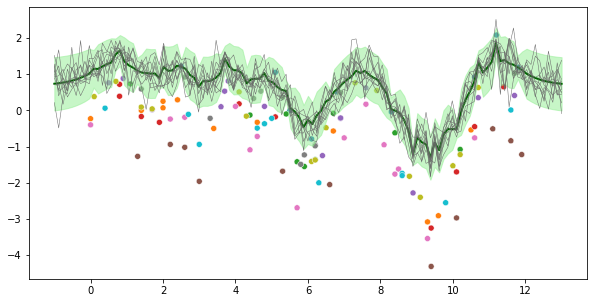

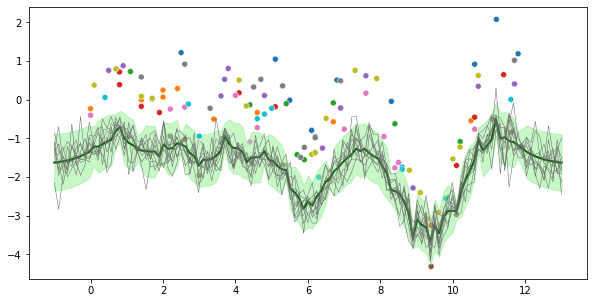

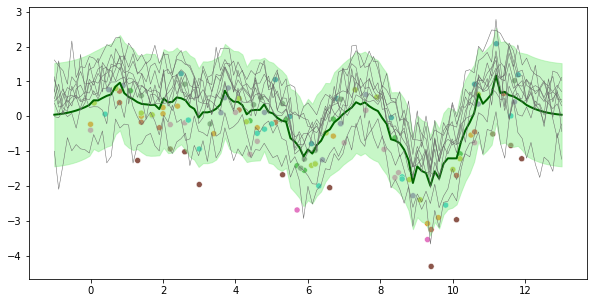

In [179]:
kernel_list = [gpflow.kernels.Constant(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Matern32(),
               gpflow.kernels.SquaredExponential(),
               gpflow.kernels.White()]
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k1_obs']].to_numpy().reshape(-1,1)
m1_best = kernel_search(X, Y, kern_list=kernel_list, max_depth=5, cat_vars=[0,1])
gp_predict_fun(gp=m1_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
gp_predict_fun(gp=m1_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=5)
gp_predict_fun(gp=m1_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10)

Kernel 2

Starting depth 0
Working on feature 0
Addition tests
['constant', 'coregion']
361.19
Working on feature 1
Addition tests
['constant', 'coregion']
393.93
Working on feature 2
Addition tests
constant
380.17
linear
409.2
matern32
384.93
squared_exponential
384.93
white
449.18
Found better kernel in current layer!
Best kernel from round 0 is constant+coregion from feature 0 with bic 361.19

Starting depth 1
Working on feature 0
Addition tests
['constant*coregion', 'constant*coregion']
375.48
['constant', 'coregion', 'coregion']
370.72
Working on feature 1
Addition tests
['constant*coregion', 'constant*coregion']
370.8
['constant', 'coregion', 'coregion']
370.72
Working on feature 2
Addition tests
['constant*coregion', 'constant']
358.84
['constant*coregion', 'linear']
365.95
['constant*coregion', 'matern32']
365.75
['constant*coregion', 'squared_exponential']
365.24
['constant*coregion', 'white']
365.95
['constant', 'coregion', 'constant']
365.95
['constant', 'coregion', 'linear']
400.1
['

<AxesSubplot:>

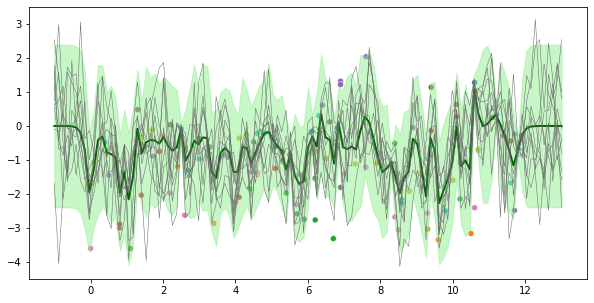

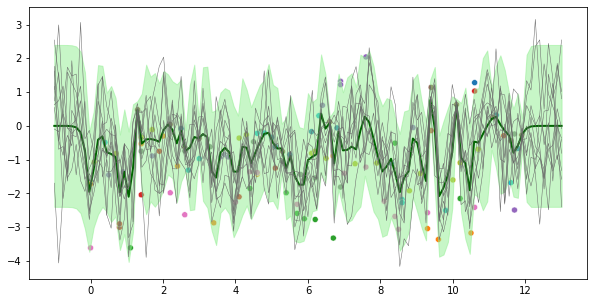

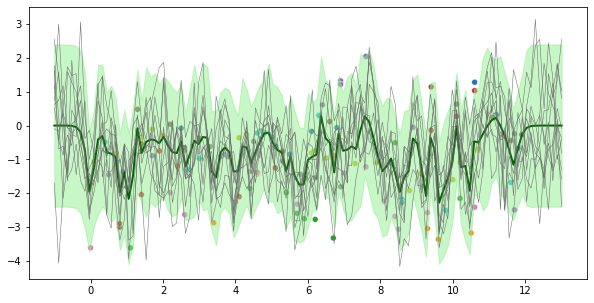

In [180]:
kernel_list = [gpflow.kernels.Constant(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Matern32(),
               gpflow.kernels.SquaredExponential(),
               gpflow.kernels.White()]
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k2_obs']].to_numpy().reshape(-1,1)
m2_best = kernel_search(X, Y, kern_list=kernel_list, max_depth=5, cat_vars=[0,1])
gp_predict_fun(gp=m2_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
gp_predict_fun(gp=m2_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=5)
gp_predict_fun(gp=m2_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10)

Starting depth 0
Working on feature 0
Working on feature 1
Working on feature 2
Best kernel from round 0 is coregion from feature 0 with bic 320.42
Found better kernel in current layer

Starting depth 1
Working on feature 0
Working on feature 1
Working on feature 2
Best kernel from round 1 is coregion+matern32 from feature 2 with bic 254.49
Found better kernel in current layer

Starting depth 2
Working on feature 0
Working on feature 1
Working on feature 2
Best kernel from round 2 is coregion*matern32+matern32 from feature 2 with bic 224.94
Found better kernel in current layer

Starting depth 3
Working on feature 0
Working on feature 1
Working on feature 2
Best kernel from round 3 is coregion*matern32+matern32+coregion from feature 0 with bic 224.45
Found better kernel in current layer

Starting depth 4
Working on feature 0
Working on feature 1
Working on feature 2
Best kernel from round 4 is coregion*matern32+matern32+coregion from feature 0 with bic 224.45
No better kernels, stopping

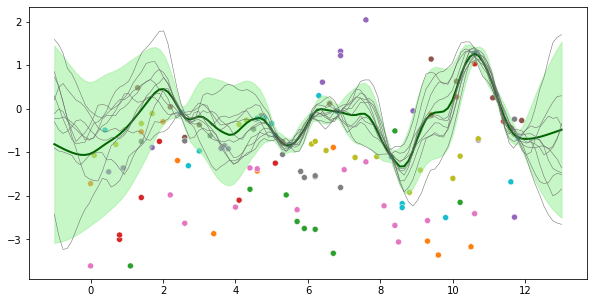

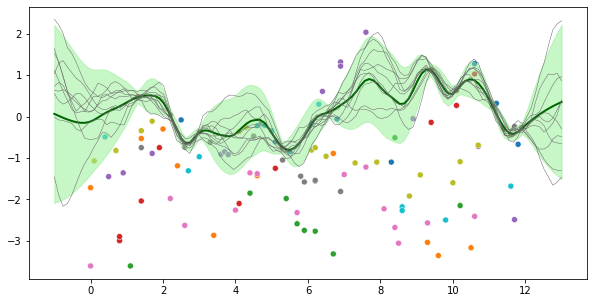

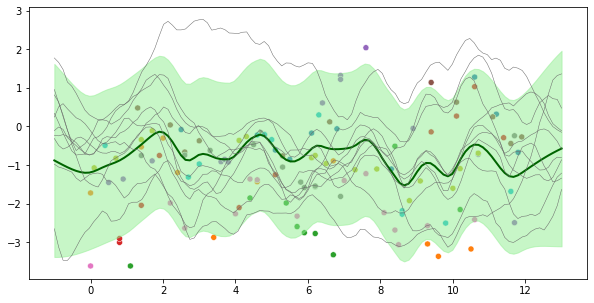

In [24]:
kernel_list = [gpflow.kernels.Constant(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Matern32(),
               gpflow.kernels.SquaredExponential(),
               gpflow.kernels.White()]
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k2_obs']].to_numpy().reshape(-1,1)
m2_best = kernel_search(X, Y, kern_list=kernel_list, max_depth=5, cat_vars=[0,1])
gp_predict_fun(gp=m2_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
gp_predict_fun(gp=m2_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=5)
gp_predict_fun(gp=m2_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10)

Kernel 3

Starting depth 0
Working on feature 0
Addition tests
['constant', 'coregion']
475.67
Working on feature 1
Addition tests
['constant', 'coregion']
485.47
Working on feature 2
Addition tests
constant
487.55
linear
400.4
matern32
411.0
squared_exponential
409.73
white
573.33
Found better kernel in current layer!
Best kernel from round 0 is linear from feature 2 with bic 400.4

Starting depth 1
Working on feature 0
Addition tests
['linear', 'constant*coregion']
270.97
['linear', 'coregion']
250.81
Working on feature 1
Addition tests
['linear', 'constant*coregion']
385.53
['linear', 'coregion']
348.52
Working on feature 2
Addition tests
['linear', 'constant']
404.78
['linear', 'linear']
400.4
['linear', 'matern32']
409.54
['linear', 'squared_exponential']
409.54
['linear', 'white']
405.16
['linear', 'constant']
405.16
['linear', 'linear']
418.44
['linear', 'matern32']
409.92
['linear', 'squared_exponential']
409.92
['linear', 'white']
517.38
Found better kernel in current layer!
Best kernel

<AxesSubplot:>

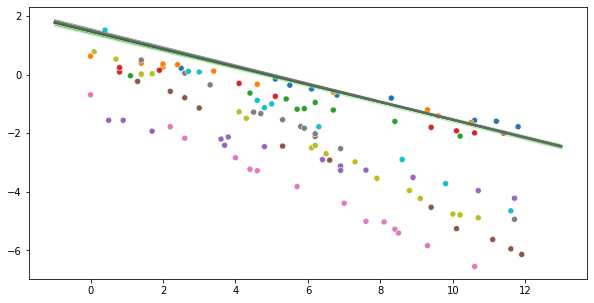

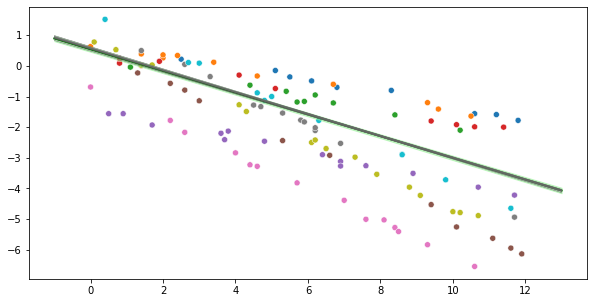

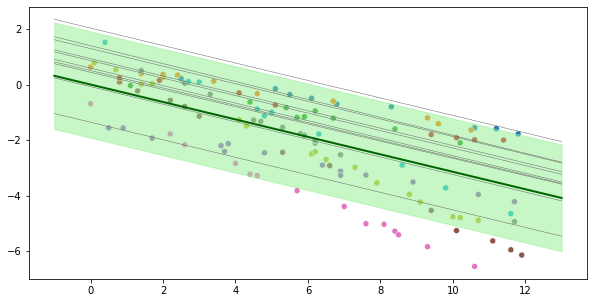

In [181]:
kernel_list = [gpflow.kernels.Constant(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Matern32(),
               gpflow.kernels.SquaredExponential(),
               gpflow.kernels.White()]
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k3_obs']].to_numpy().reshape(-1,1)
m3_best = kernel_search(X, Y, kern_list=kernel_list, max_depth=5, cat_vars=[0,1])
gp_predict_fun(gp=m3_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
gp_predict_fun(gp=m3_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=9)
gp_predict_fun(gp=m3_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10)

Starting depth 0
Working on feature 0
Working on feature 1
Working on feature 2
Best kernel from round 0 is linear from feature 2 with bic 400.4
Found better kernel in current layer

Starting depth 1
Working on feature 0
Working on feature 1
Working on feature 2
Best kernel from round 1 is linear+coregion from feature 0 with bic 245.42
Found better kernel in current layer

Starting depth 2
Working on feature 0
Working on feature 1
Working on feature 2
Best kernel from round 2 is linear*coregion+coregion from feature 0 with bic -33.12
Found better kernel in current layer

Starting depth 3
Working on feature 0
Working on feature 1
Working on feature 2
Best kernel from round 3 is linear*coregion+coregion+linear from feature 2 with bic -60.74
Found better kernel in current layer

Starting depth 4
Working on feature 0
Working on feature 1
Working on feature 2
Best kernel from round 4 is linear*coregion+coregion+linear+coregion from feature 1 with bic -79.52
Found better kernel in current la

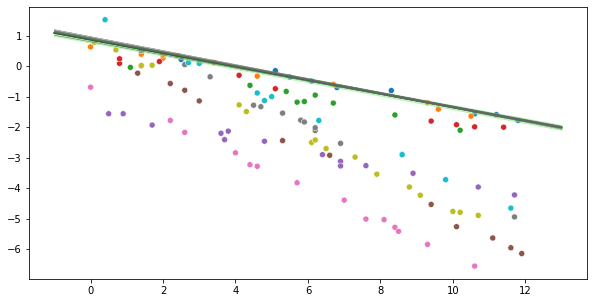

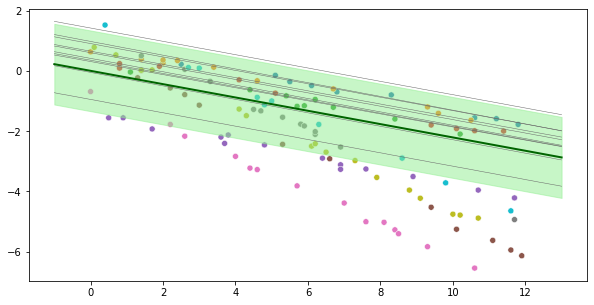

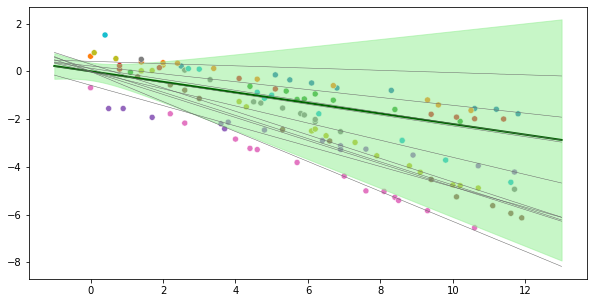

In [27]:
kernel_list = [gpflow.kernels.Constant(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Matern32(),
               gpflow.kernels.SquaredExponential(),
               gpflow.kernels.White()]
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k3_obs']].to_numpy().reshape(-1,1)
m3_best = kernel_search(X, Y, kern_list=kernel_list, max_depth=5, cat_vars=[0,1])
gp_predict_fun(gp=m3_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
gp_predict_fun(gp=m3_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=9)
gp_predict_fun(gp=m3_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10)

Kernel 4

Starting depth 0
Working on feature 0
Addition tests
['constant', 'coregion']
633.13
Working on feature 1
Addition tests
['constant', 'coregion']
631.33
Working on feature 2
Addition tests
constant
690.76
linear
687.96
matern32
694.73
squared_exponential
694.65
white
697.06
Found better kernel in current layer!
Best kernel from round 0 is constant+coregion from feature 1 with bic 631.33

Starting depth 1
Working on feature 0
Addition tests
['constant*coregion', 'constant*coregion']
637.66
['constant', 'coregion', 'coregion']
642.66
Working on feature 1
Addition tests
['constant*coregion', 'constant*coregion']
645.62
['constant', 'coregion', 'coregion']
640.86
Working on feature 2
Addition tests
['constant*coregion', 'constant']
636.1
['constant*coregion', 'linear']
633.88
['constant*coregion', 'matern32']
639.04
['constant*coregion', 'squared_exponential']
638.94
['constant*coregion', 'white']
636.1
['constant', 'coregion', 'constant']
636.1
['constant', 'coregion', 'linear']
512.01
['

<AxesSubplot:>

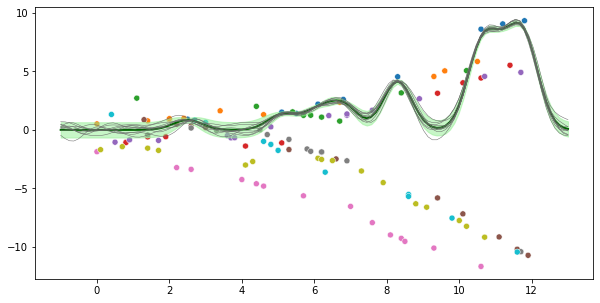

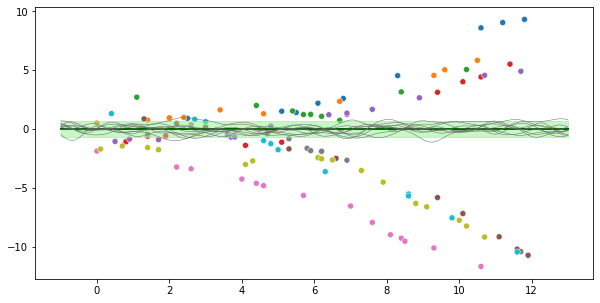

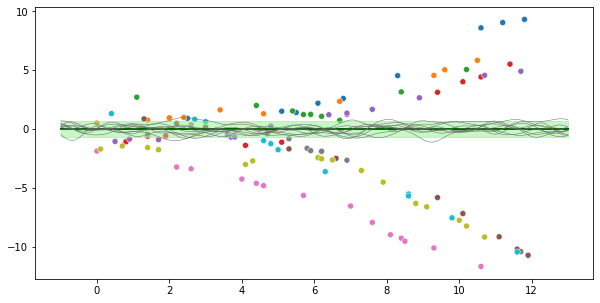

In [182]:
kernel_list = [gpflow.kernels.Constant(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Matern32(),
               gpflow.kernels.SquaredExponential(),
               gpflow.kernels.White()]
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k4_obs']].to_numpy().reshape(-1,1)
m4_best = kernel_search(X, Y, kern_list=kernel_list, max_depth=5, cat_vars=[0,1])
gp_predict_fun(gp=m4_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
gp_predict_fun(gp=m4_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=9)
gp_predict_fun(gp=m4_best, X=X, Y=Y, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10)